# Solving a two-asset HANK model in sequence space

In this notebook we solve the two-asset HANK model from Auclert, Bardóczy, Rognlie, Straub (2019): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models". Please see the [Github repository](https://github.com/shade-econ/sequence-jacobian) for more information and code.

The only new concept relative to the one-asset HANK notebook is that of a **solved block**. These are extensions of simple blocks that are useful for large macro models and that's why we introduce them here in the context of our richest model. We will apply all other concepts and tools that are familiar from other notebooks here without further explanation. 

## Model description

The household problem is characterized by the Bellman equation

$$
\begin{align} \tag{1}
V_t(e_t, b_{t-1}, a_{t-1}) = \max_{c_t, b_t, a_t} &\left\{\frac{c_t^{1-\sigma}}{1-\sigma} + \beta E_t V_{t+1}(e_{t+1}, b_t, a_t) \right\}
\\
c_t + a_t + b_t &= (1-\tau_t)w_t n_t e_t + (1 + r_t^a)a_{t-1} + (1 + r_t^b)b_{t-1} - \Psi(a_t, a_{t-1}) 
\\
a_t &\geq 0, \quad b_t \geq \underline{b},
\end{align}
$$

where the adjustment cost function is specified as

$$
\Psi(a_t, a_{t-1}) =  \frac{\chi_1}{\chi_2}\left|\frac{a_t - (1 + r_t^a) a_{t-1}}{(1 + r_{t}^a) a_{t-1} + \chi_0}\right|^{\chi_2} \left[(1 + r_t^a) a_{t-1} + \chi_0 \right],
$$

with $\chi_0, \chi_1 > 0$ and $\chi_2 > 1.$ For the full description of the model, including the problems of the other agents, please see appendix A.3 of the paper.

## 0 Import packages

The first two are standard python packages, the rest contain code we wrote for this project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import utils
import jacobian as jac
from het_block import het
from simple_block import simple
from solved_block import solved
import two_asset
import nonlinear
import determinacy as det

## 1 Calibrate steady state

We developed an efficient backward iteration function to solve the Bellman equation in (1). Although we view this as a contribution on its own, discussing the algorithm goes beyond the purposes of this notebook. If you are interested in how we solve a two-asset model with convex portfolio-adjustment costs in discrete time, please see appendix B of the paper for a detailed description and `two_asset.py` for the implementation.

In [2]:
ss = two_asset.hank_ss(noisy=False)

## 2 Define simple blocks

Compare these to the equations in appendix A.3 of the paper.

In [3]:
@simple
def dividend(Y, w, N, K, pi, mup, kappap, delta):
    psip = mup / (mup - 1) / 2 / kappap * np.log(1 + pi) ** 2 * Y
    I = K - (1 - delta) * K(-1)
    div = Y - w * N - I - psip
    return psip, I, div

@simple
def taylor(rstar, pi, phi):
    i = rstar + phi * pi
    return i

@simple
def fiscal(r, w, N, G, Bg):
    tax = (r * Bg + G) / w / N
    return tax

@simple
def finance(i, p, pi, r, div, omega, pshare):
    rb = r - omega
    ra = pshare * (div + p) / p(-1) + (1-pshare) * (1 + r) - 1
    fisher = 1 + i(-1) - (1 + r) * (1 + pi)
    return rb, ra, fisher

@simple
def wage(pi, w, N, muw, kappaw):
    piw = (1 + pi) * w / w(-1) - 1
    psiw = muw / (1 - muw) / 2 / kappaw * np.log(1 + piw) ** 2 * N
    return piw, psiw

@simple
def union(piw, N, tax, w, U, kappaw, muw, vphi, frisch, beta):
    wnkpc = kappaw * (vphi * N**(1+1/frisch) - muw*(1-tax)*w*N*U) + beta * np.log(1 + piw(+1)) - np.log(1 + piw)
    return wnkpc

@simple
def mkt_clearing(p, A, B, Bg):
    asset_mkt = p + Bg - B - A
    return asset_mkt

## 3 Define solved blocks

Solved blocks are mini SHADE models embedded as blocks inside larger SHADE models. Like simple blocks, solved blocks correspond to aggregate equilibrium conditions: they map sequences of aggregate inputs directly into sequences of aggregate outputs. The difference is that in the case of simple blocks, this mapping has to be analytical, while solved blocks are designed to accommodate implicit relationships that can only be evaluated numerically. 

Such implicit mappings between variables become more common as macro complexity increases. Solved blocks are a valuable tool to simplify the DAG of large macro models.

### 3.1 Price setting 
The Phillips curve characterizes $(\pi)$ conditional on $(Y, mc, r):$ 

$$
\log(1+\pi_t) = \kappa_p \left(mc_t - \frac{1}{\mu_p} \right) + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1})
$$

Inflation shows up with two different time displacements, and so we could not express it analytically. Instead, we write a function that returns the residual of the equation, and use the decorator `@solved` to make it into a SolvedBlock.

In [4]:
@solved(unknowns=['pi'], targets=['nkpc'])
def pricing(pi, mc, r, Y, kappap, mup):
    nkpc = kappap * (mc - 1/mup) + Y(+1) / Y * np.log(1 + pi(+1)) / (1 + r(+1)) - np.log(1 + pi)
    return nkpc

When our routines encounter a solved block in `block_list`, they compute its Jacobian via the the implicit function theorem, as if it was a SHADE model on its own. Given the Jacobian, the rest of the code applies without modification. 

### 3.2 Equity price
The no arbitrage condition characterizes $(p)$ conditional on $(d, p, r).$

$$
p_t = \frac{d_{t+1} + p_{t+1}}{1 + r_{t+1}}
$$

In [5]:
@solved(unknowns=['p'], targets=['equity'])
def arbitrage(div, p, r):
    equity = div(+1) + p(+1) - p * (1 + r(+1))
    return equity

### 3.3 Investment with adjustment costs

Sometimes multiple equilibrium conditions can be combined in a self-contained solved block. Investment subject to capital adjustment costs is such a case. In particular, we can use the following four equations to solve for $(K, Q)$ conditional on $(Y, w, r)$.
 
 - Production:
 
 $$
 Y_t = Z_t K_{t-1}^\alpha N_t^{1-\alpha}
 $$
 
 - Labor demand:
 
 $$
 w_t = (1-\alpha)\frac{Y_t}{N_t} mc_t
 $$
 
 - Investment equation:

$$
Q_t = 1 + \frac{1}{\delta \epsilon_I}\left(\frac{K_t-K_{t-1}}{K_{t-1}}\right)
$$

- Valuation equation

$$
(1+r_{t})Q_{t} = \alpha Z_{t+1} \left(\frac{N_{t+1}}{K_t}\right)^{1-\alpha} mc_{t+1} - \left[\frac{K_{t+1}}{K_t} - (1-\delta) + \frac{1}{2\delta \epsilon_I}\left(\frac{K_{t+1} - K_t}{K_t}\right)^2\right] + \frac{K_{t+1}}{K_t}Q_{t+1}
$$

Solved blocks that contain multiple simple blocks have to be initialized with `solved_block.solved` function instead of the decorator `@solved`.

In [6]:
@simple
def labor(Y, w, K, Z, alpha):
    N = (Y / Z / K(-1) ** alpha) ** (1 / (1 - alpha))
    mc = w * N / (1 - alpha) / Y
    return N, mc

@simple
def investment(Q, K, r, N, mc, Z, delta, epsI, alpha):
    inv = (K/K(-1) - 1) / (delta * epsI) + 1 - Q
    val = alpha * Z(+1) * (N(+1) / K) ** (1-alpha) * mc(+1) - (K(+1)/K -
           (1-delta) + (K(+1)/K - 1)**2 / (2*delta*epsI)) + K(+1)/K*Q(+1) - (1 + r(+1))*Q
    return inv, val

production = solved(block_list=[labor, investment],
                    unknowns=['Q', 'K'],
                    targets=['inv', 'val'])

## 4 Determinacy check

Let's start by defining the inputs common across our convenience functions. Since computing the Jacobian of this two-asset HA block is somewhat costly, it's a good idea to save it for subsequent use.

In [7]:
T = 500
block_list = [two_asset.household_inc, pricing, arbitrage, production, 
              dividend, taylor, fiscal, finance, wage, union, mkt_clearing]
exogenous = ['rstar', 'Z', 'G']
unknowns = ['r', 'w', 'Y']
targets = ['asset_mkt', 'fisher', 'wnkpc']

We are ready to apply the winding number criterion. Recall that a winding number of 0 indicates that the model has a unique solution around the steady state, while a winding number of -1 or less indicates indeterminacy.

In [8]:
A = jac.get_H_U(block_list, unknowns, targets, T, ss, asymptotic=True, save=True)
wn = det.winding_criterion(A)
print(f'Winding number: {wn}')

Winding number: 0


## Linearized dynamics

Computing $G$ is fast using the saved HA Jacobian.

In [9]:
G = jac.get_G(block_list, exogenous, unknowns, targets, T=T, ss=ss, use_saved=True)

Let's plot some impulse responses:

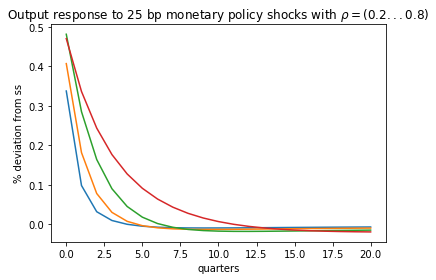

In [10]:
rhos = np.array([0.2, 0.4, 0.6, 0.8])
drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])
dY = 100 * G['Y']['rstar'] @ drstar

plt.plot(dY[:21])
plt.title(r'Output response to 25 bp monetary policy shocks with $\rho=(0.2 ... 0.8)$')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')
plt.show()

## Nonlinear impulse responses

Don't forget to use the saved Jacobian.

In [11]:
td_nonlin = nonlinear.td_solve(ss, block_list, unknowns, targets, rstar=ss['r']+drstar[:,2], use_saved=True)

On iteration 0
   max error for asset_mkt is 4.63E-06
   max error for fisher is 2.50E-03
   max error for wnkpc is 6.74E-08
On iteration 1
   max error for asset_mkt is 2.79E-04
   max error for fisher is 1.50E-06
   max error for wnkpc is 2.61E-05
On iteration 2
   max error for asset_mkt is 8.78E-06
   max error for fisher is 1.00E-07
   max error for wnkpc is 7.67E-07
On iteration 3
   max error for asset_mkt is 5.16E-07
   max error for fisher is 2.63E-09
   max error for wnkpc is 2.08E-08
On iteration 4
   max error for asset_mkt is 3.13E-08
   max error for fisher is 1.40E-10
   max error for wnkpc is 1.03E-09
On iteration 5
   max error for asset_mkt is 1.92E-09
   max error for fisher is 7.95E-12
   max error for wnkpc is 5.64E-11


Comparing the linear and nonlinear responses is always a great way to verify that we did not make mistakes.

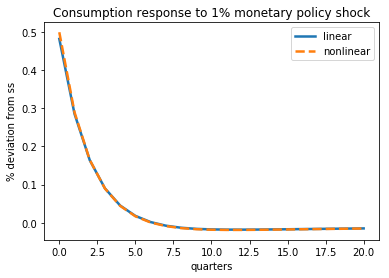

In [12]:
dY_nonlin = 100 * (td_nonlin['Y'] - 1) 

plt.plot(dY[:21, 2], label='linear', linestyle='-', linewidth=2.5)
plt.plot(dY_nonlin[:21], label='nonlinear', linestyle='--', linewidth=2.5)
plt.title(r'Consumption response to 1% monetary policy shock')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')
plt.legend()
plt.show()